# Model: LSTM

## Objective:
Our goal is to predict the **road condition type** based on vehicle sensor readings over time.
Specifically, we want to classify whether the vehicle is on:
- Asphalt
- Cobblestone
- Dirt Road

We will be using the **cleaned dataset** prepared from `01_data_cleaning.ipynb`.

## Dataset:
- Path: `dataset/cleaned_master_dataset.csv`
- Shape: 1,080,905 rows, 81 columns (after cleaning)

## Tasks Overview:
- Load the cleaned dataset
- Basic data exploration (optional, feel free to plot if needed)
- Reshape data into sequences for LSTM input
- Train **LSTM Model**
- Evaluate performance (Accuracy, Confusion Matrix, etc.)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Run the cell below if you need to run LSTM on your Mac M2 Chip ONLY

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("List of Physical Devices:", tf.config.list_physical_devices())
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

# Disable GPU acceleration (force CPU execution)
tf.config.set_visible_devices([], 'GPU')

print("Running TensorFlow on CPU only")

TensorFlow version: 2.18.0
List of Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Is GPU available? []
Running TensorFlow on CPU only


In [3]:
# Load the cleaned master dataset
df = pd.read_csv('../dataset/cleaned_master_dataset.csv')

# Quick check
print(df.shape)
print(df.head())

(1080905, 81)
      timestamp  acc_x_dashboard_left  acc_y_dashboard_left  \
0  1.577219e+09              0.365116              0.167893   
1  1.577219e+09              0.392649              0.176273   
2  1.577219e+09              0.409408              0.181062   
3  1.577219e+09              0.371101              0.164302   
4  1.577219e+09              0.390255              0.159514   

   acc_z_dashboard_left  acc_x_above_suspension_left  \
0              9.793961                     0.327626   
1              9.771216                     0.381496   
2              9.732909                     0.283333   
3              9.749668                     0.314458   
4              9.869378                     0.344385   

   acc_y_above_suspension_left  acc_z_above_suspension_left  \
0                     0.172733                     9.781861   
1                     0.189492                     9.699261   
2                     0.182310                     9.807000   
3                 

## Some EDA here

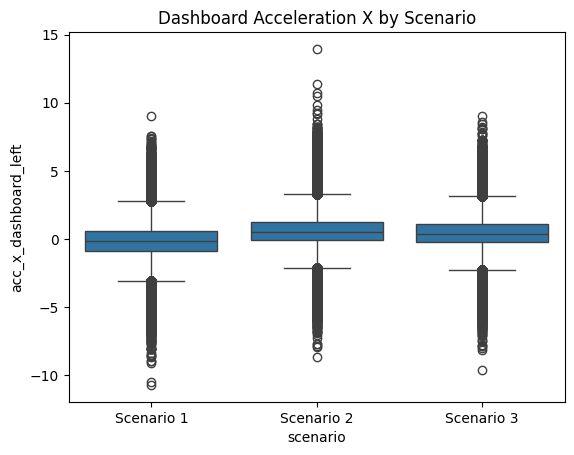

In [4]:
sns.boxplot(x='scenario', y='acc_x_dashboard_left', data=df)
plt.title('Dashboard Acceleration X by Scenario')
plt.show()

In [5]:
# Select Features (Time-Series Sensor Example)
features = df[['acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left']].values
target = df['dirt_road'].values  # Example: Predicting dirt road (0 or 1)

# Reshape data for LSTM [samples, time_steps, features]
# Here we use a simple window approach, e.g., 10 time steps per sample
sequence_length = 10

X = []
y = []

for i in range(len(features) - sequence_length):
    X.append(features[i:i + sequence_length])
    y.append(target[i + sequence_length])

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

X shape: (1080895, 10, 3), y shape: (1080895,)
Epoch 1/3


/Users/ajmaljalal/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12161/12161 ━━━━━━━━━━━━━━━━━━━━ 88s 7ms/step - accuracy: 0.7896 - loss: 0.4219 - val_accuracy: 0.8170 - val_loss: 0.3806
Epoch 2/3
12161/12161 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.8161 - loss: 0.3759 - val_accuracy: 0.8263 - val_loss: 0.3626
Epoch 3/3
12161/12161 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.8221 - loss: 0.3658 - val_accuracy: 0.8284 - val_loss: 0.3549
6756/6756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8252 - loss: 0.3581
Test Accuracy: 0.8258


In [15]:
# Save the model (optional)
model.save('../api/models/lstm_road_condition_model.keras')
print("\nModel saved as 'lstm_road_condition_model.keras'")


Model saved as 'lstm_road_condition_model.keras'



Sequence shapes:
X shape: (1080885, 20, 9), y shape: (1080885,)

Model Architecture:


/Users/ajmaljalal/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 20, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 20, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,785 (135.88 KB)

 Trainable params: 34,785 (135.88 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/10
10809/10809 ━━━━━━━━━━━━━━━━━━━━ 162s 15ms/step - accuracy: 0.8246 - auc_4: 0.9164 - loss: 0.3554 - precision_4: 0.6372 - recall_4: 0.8711 - val_accuracy: 0.8817 - val_auc_4: 0.9612 - val_loss: 0.2595 - val_precision_4: 0.7224 - val_recall_4: 0.9260 - learning_rate: 3.2019e-04
Epoch 2/10
10809/10809 ━━━━━━━━━━━━━━━━━━━━ 172s 16ms/step - accuracy: 0.8859 - auc_4: 0.9614 - loss: 0.2468 - precision_4: 0.7346 - recall_4: 0.9209 - val_accuracy: 0.8931 - val_auc_4: 0.9682 - val_loss: 0.2343 - val_precision_4: 0.7431 - val_recall_4: 0.9348 - learning_rate: 1.0252e-04
Epoch 3/10
10809/10809 ━━━━━━━━━━━━━━━━━━━━ 169s 16ms/step - accuracy: 0.8944 - auc_4: 0.9666 - loss: 0.2291 - precision_4: 0.7500 - recall_4: 0.9290 - val_accuracy: 0.8989 - val_auc_4: 0.9697 - val_loss: 0.2248 - val_precision_4: 0.7568 - val_recall_4: 0.9321 - learning_rate: 3.2826e-05
Epoch 4/10
10809/10809 ━━━━━━━━━━━━━━━━━━━━ 165s 15ms/step - accuracy: 0.8969 - auc_4: 0.9684 - loss: 0.2222 -

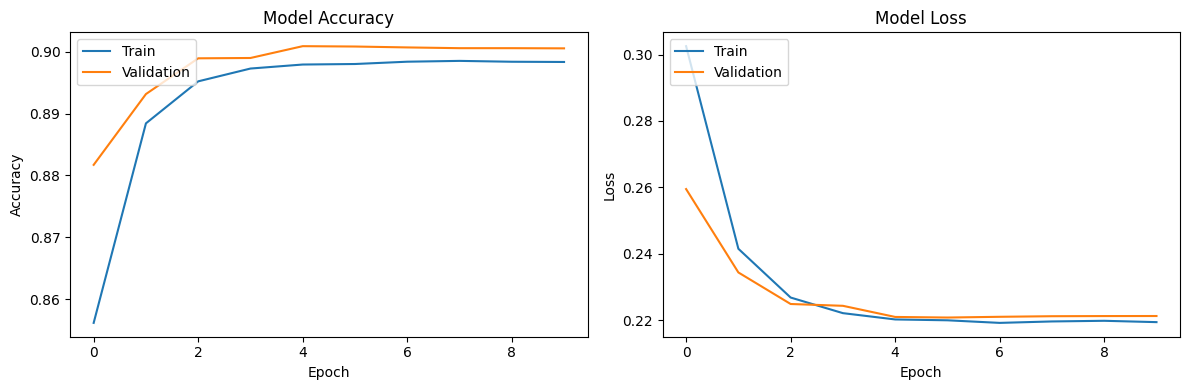


Evaluating the model on test data...
6756/6756 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8999 - auc_4: 0.9704 - loss: 0.2207 - precision_4: 0.7612 - recall_4: 0.9322

Test Results:
loss: 0.2200
compile_metrics: 0.9005
6756/6756 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


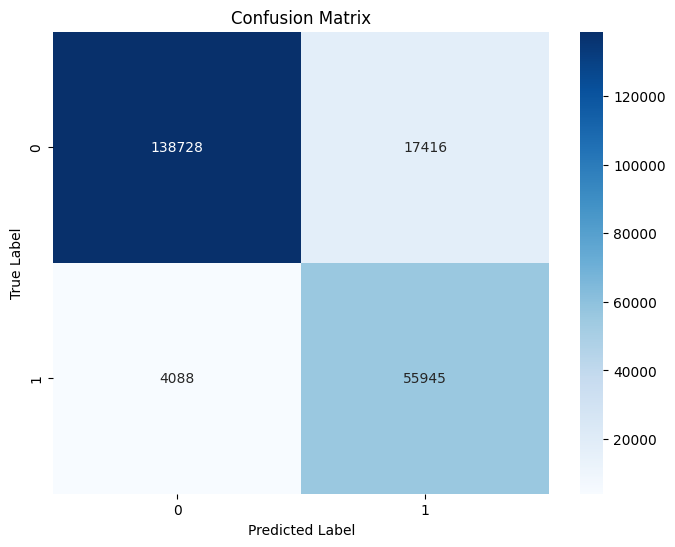


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    156144
           1       0.76      0.93      0.84     60033

    accuracy                           0.90    216177
   macro avg       0.87      0.91      0.88    216177
weighted avg       0.91      0.90      0.90    216177



In [10]:
# Model: LSTM Optimized
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# Select additional features
features = df[[
    'acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left',
    'acc_x_dashboard_right', 'acc_y_dashboard_right', 'acc_z_dashboard_right',
    'gyro_x_dashboard_left', 'gyro_y_dashboard_left', 'gyro_z_dashboard_left'
]].values

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Define sequence parameters
sequence_length = 20  # Increased from 10

# Create sequences for LSTM
X = []
y = []

for i in range(len(features) - sequence_length):
    X.append(features[i:i + sequence_length])
    y.append(target[i + sequence_length])

X = np.array(X)
y = np.array(y)

print(f"\nSequence shapes:")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define learning rate schedule
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

# Build enhanced LSTM Model
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(sequence_length, features.shape[1])),  # Reduced from 128
    Dropout(0.3),
    LSTM(units=32, return_sequences=True),  # Reduced from 64
    Dropout(0.3),
    LSTM(units=16),  # Reduced from 32
    Dropout(0.3),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Model summary
print("\nModel Architecture:")
model.summary()

# Compile Model with additional metrics
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

# Train Model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    epochs=10,  # Reduced from 50
    batch_size=64,  # Increased from 32 for faster training
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate and print detailed metrics
print("\nEvaluating the model on test data...")
test_results = model.evaluate(X_test, y_test)
print("\nTest Results:")
for metric_name, value in zip(model.metrics_names, test_results):
    print(f"{metric_name}: {value:.4f}")

# Generate predictions and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

In [14]:
# Save the model (optional)
model.save('../api/models/lstm_road_condition_model_optimized.keras')
print("\nModel saved as 'lstm_road_condition_model_optimized.keras'")


Model saved as 'lstm_road_condition_model_optimized.keras'
